In [1]:
from cil.optimisation.functions import L2NormSquared
from cil.utilities import dataexample
from cil.optimisation.functions import TotalVariation
import numpy as np
import matplotlib.pyplot as plt
from cil.utilities.display import show2D
import cupy as cp
import dask.array as da
from cil.plugins import TomoPhantom
from cil.framework import ImageGeometry
from cil.plugins.ccpi_regularisation.functions import FGP_TV
import time

In [2]:
# data = dataexample.CAMERA.get(size=(1024,1024))
ig = ImageGeometry(1000,1000,1000)
data = TomoPhantom.get_ImageData(3, ig)

In [3]:
alpha = 2

In [4]:
# use TotalVariation from CIL (with Fast Gradient Projection algorithm)
# TV = alpha * TotalVariation(max_iteration=10)

TV = FGP_TV(alpha=alpha, max_iteration=5, device='cpu')

In [5]:
t1 = time.time()
u_cil = TV.proximal(data, tau=1.0)
t2 = time.time()
print(t2-t1)

54.562636375427246


In [6]:
from cucim.skimage import restoration as restoration_gpu

In [7]:
# from dask_cuda import LocalCUDACluster
# from dask.distributed import Client

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

import time


if __name__ == "__main__":
    
    # cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1")
    # client = Client(cluster)  
    cluster = LocalCUDACluster(n_workers=2)

    print("cluster status ",cluster.status)
    print("cluster infomarion ", cluster)    
    
    client = Client(cluster)   
    print("client information ",client)

    # res = restoration_gpu.denoise_tv_chambolle(cp.array(data.array), weight=alpha, eps=1e-12, n_iter_max=4000, multichannel=False)
    def denoise_gpu(x, weight=alpha, eps=1e-12, n_iter_max=5):

        x = cp.asarray(x, dtype=np.float32)
        # x = x.mean(0)

        y = restoration_gpu.denoise_tv_chambolle(
            x,
            weight=weight,
            eps=eps,
            n_iter_max=n_iter_max,
        )

        return cp.asnumpy(y)
    
    denoise_func = denoise_gpu
    
    
    data_dask = da.from_array(data.array, chunks=(500,200,500))

    # apply denoise_gpu over all blocks of the input
    denoised = da.map_overlap(
        denoise_func,
        data_dask,
        depth=(0, 1, 1, 1),  # bug fixed in: https://github.com/dask/dask/pull/7894
        boundary='reflect',
        # drop_axis=(0,),
        trim=True,
        dtype=np.float32,
    )

    t1 = time.time()
    res = denoised.compute() 
    t2 = time.time()
    print(t2-t1)
    # %%time
    # res = denoised.compute(scheduler="threads")
    
    client.close()


distributed.diskutils - INFO - Found stale lock file and directory '/home/sirf/dask-worker-space/worker-dumoyc4j', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sirf/dask-worker-space/worker-4a_t441g', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sirf/dask-worker-space/worker-3ui6i9e6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sirf/dask-worker-space/worker-x9vf2vob', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sirf/dask-worker-space/worker-zm2aniwf', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sirf/dask-worker-space/worker-ce3jlw02', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sirf/dask-worker-space/worker-b2c9ye_x', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sirf/dask-worker-space/worker-4ms1ch6u', purging
distributed.disk

cluster status  Status.running
cluster infomarion  LocalCUDACluster(70142d26, 'tcp://127.0.0.1:46235', workers=2, threads=2, memory=177.10 GiB)
client information  <Client: 'tcp://127.0.0.1:46235' processes=2 threads=2, memory=177.10 GiB>
38.07888150215149


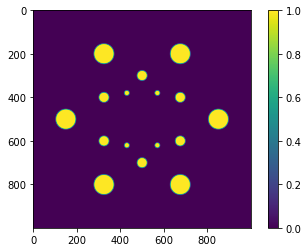

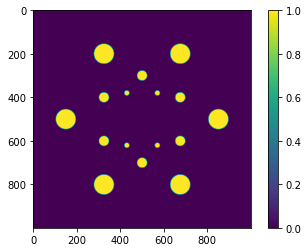

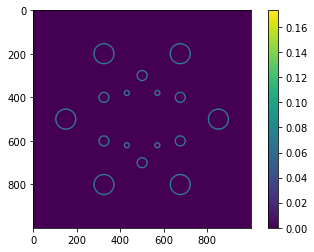

In [9]:
plt.figure()
plt.imshow(res[100])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(u_cil.array[100])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.abs(res[100] - u_cil.array[100]))
plt.colorbar()
plt.show()